###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2021 Semester 1

## Assignment 1: Pose classification with naive Bayes


**Student ID(s):**     `1182728`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [32]:
import pandas as pd

from collections import defaultdict
import numpy as np
import math
from sklearn.utils.multiclass import unique_labels
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [27]:
# This function reads the data from a file and converting it into a dictionary of class:attributes 
# drop the instance if all attributes are missing 

def preprocess(filename):
    f = pd.read_csv(filename, na_values = "9999.0000", header = None)
    
    # delete instances with all missing values
    f = f.dropna(axis=0, how='all', subset = [i for i in range(1, f.shape[1])])
    
    # convert the format of the data into a dictionary 
    data = defaultdict(list)
    
    for i in range(len(f)):
        data[list(f.iloc[i])[0]].append(list(f.iloc[i])[1:])
   
    return data


In [28]:
# This function calculates prior probabilities and likelihoods from the training data and using them to build a naive Bayes model

def train(train_data):
    
    # the total number of attribtues in training data
    total_num = sum([len(train_data[i]) for i in train_data.keys()])
    
    # the prior possibility of each class 
    prior_class = []
    
    # a dictionary containing the mean and sd of each attribute from each class 
    stats = defaultdict(list)
    
    for i in train_data.keys():
        
        # compute the priors for each class 
        prior_class.append(len(train_data[i])/total_num)
        
        # compute the mean and standard deviations, ignoring missing values 
        stats[i].append(np.nanmean(train_data[i], axis = 0))
        stats[i].append(np.nanstd(train_data[i], axis = 0))

    return (stats, prior_class)


In [29]:
# This function predicts classes for new items in a test dataset 
def predict(stats, priors, test_file):

    f = pd.read_csv(test_file, na_values = "9999.0000", header = None)
    
    y_test = list(f[0])
    
    # distinct classes 
    classes = list(stats.keys())

    pi = [math.sqrt(2*math.pi)] * (f.shape[1]-1)
    
    # predicted labels and results
    labels = []

    # for each row in the data 
    for i in range(f.shape[0]):
        
        # compute log(prior_possibilities)
        prior = np.log(priors)
        
        # a list of attribute values
        attr = list(f.iloc[i])[1:]
        
        # a 1d array containing the likelihoods 
        p_ij = np.zeros(len(classes))
        
        for j in range(len(classes)):
            
            c = classes[j]
            mean = stats[c][0]
            sd = stats[c][1]
            
            p_xc = 1/(sd * pi) * np.exp(-0.5* np.power((attr - mean)/sd, 2))
            p_xc = np.log(p_xc)
            
            
            # a way to deal with zero values
            p_xc = np.nan_to_num(p_xc, nan=0.0)
            p_ij[j] = np.sum(p_xc)
            
        sums = prior + p_ij
        labels.append(classes[np.argmax(sums)])
        
    return (y_test, labels)

In [30]:
# This function evaluates the prediction performance by comparing your model’s class outputs to ground truth labels

def evaluate(y_test, y_pred):
    
    correct = 0
        
    for i in range(len(y_test)):
        if y_pred[i] == y_test[i]:
            correct += 1

    total_accuracy = correct / len(y_pred)

    return total_accuracy


In [45]:
# a function that accepts a training file and a testing file, and then returns the accuracy score 

def GNB(train_file, test_file, extend):
    train_data = preprocess(train_file)
    stats, priors = train(train_data)
    y_test, y_pred = predict(stats, priors, test_file)
    
    # if we need extended evaluation
    if extend:
        return evaluate_extend(y_test, y_pred)
    
    return evaluate(y_test, y_pred)

print(GNB("train.csv", "test.csv", True))


Micro-Averaging -> Precision: 0.74, Recall: 0.74, F_Score: 0.74
Macro-Averaging -> Precision: 0.74, Recall: 0.72, F_Score: 0.72
Weighted-Averaging -> Precision: 0.74, Recall: 0.75, F_Score: 0.74
0.74


## Questions 


If you are in a group of 1, you will respond to **two** questions of your choosing.

If you are in a group of 2, you will respond to **four** questions of your choosing.

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer should be submitted separately as a PDF.

### Q1
Since this is a multiclass classification problem, there are multiple ways to compute precision, recall, and F-score for this classifier. Implement at least two of the methods from the "Model Evaluation" lecture and discuss any differences between them. (The implementation should be your own and should not just call a pre-existing function.)

In [44]:
from sklearn.metrics import confusion_matrix

def evaluate_extend(y_test, y_pred):
    
    labels = y_pred
    classes = y_test
    
    n_classes = len(unique_labels(classes))
    
    # print(confusion_matrix(classes, labels))
    
    correct =0
        
    tp = defaultdict(int)
    fp = defaultdict(int)
    fn = defaultdict(int)
    tn = defaultdict(int)
    
    # compute the metrics for evaluation
    for i in range(len(labels)):
        
        if labels[i] == classes[i]:
            tp[classes[i]] += 1
            correct += 1
        else:
            fn[labels[i]] += 1
            fp[classes[i]] += 1
    
    # the weight fractions of each class based on their distribution 
    weight = defaultdict(float)
    
    # compute true negatives and weight fractions 
    for c in tp.keys():
        tn[c] = len(labels) - tp[c] - fp[c] - fn[c]
        weight[c] = classes.count(c) / len(classes)
        
    
    
    
    total_accuracy = correct / len(labels)
   
    precision = defaultdict(float)
    recall = defaultdict(float)
    f_score = defaultdict(float)
    
    
    for c in tp.keys():
        precision[c] = (tp[c]) / (tp[c] + fp[c])
        recall[c] = tp[c] / (tp[c] + fn[c])
        f_score[c] = (2 * precision[c] * recall[c]) / (precision[c] + recall[c])

    
    # micro-averaing
    total_tp = sum(list(tp.values()))
    total_fp = sum(fp.values())
    total_fn = sum(fn.values())
    total_tn = sum(tn.values())
    
    micro_precision = total_tp / (total_tp + total_fp)
    micro_recall = total_tp / (total_tp + total_fn)
    micro_f_score = 2 * micro_precision * micro_recall / (micro_precision + micro_recall)
    
    print('Micro-Averaging -> Precision: {:.2f}, Recall: {:.2f}, F_Score: {:.2f}'.format(micro_precision,micro_recall,micro_f_score))
        
    # macro-averaing   
    total_precision = sum(list(precision.values())) / n_classes
    total_recall = sum(list(recall.values())) / n_classes
    total_f_score = sum(list(f_score.values())) / n_classes
    
    print('Macro-Averaging -> Precision: {:.2f}, Recall: {:.2f}, F_Score: {:.2f}'.format(total_precision,total_recall,total_f_score))
    
    # weighted averaging 
    tot_prec = 0.0
    tot_recall = 0.0
    tot_f = 0.0
    
    for c in weight.keys():
        tot_prec += precision[c] * weight[c]
        tot_recall += recall[c] * weight[c]
        tot_f += f_score[c] * weight[c]
    
    print('Weighted-Averaging -> Precision: {:.2f}, Recall: {:.2f}, F_Score: {:.2f}'.format(tot_prec, tot_recall, tot_f))
    
    total_accuracy = '{:.2f}'.format(total_accuracy)
    return total_accuracy


### Q3
Implement a kernel density estimate (KDE) naive Bayes classifier and compare its performance to the Gaussian naive Bayes classifier. Recall that KDE has kernel bandwidth as a free parameter -- you can choose an arbitrary value for this, but a value in the range 5-25 is recommended. Discuss any differences you observe between the Gaussian and KDE naive Bayes classifiers. (As with the Gaussian naive Bayes, this KDE naive Bayes implementation should be your own and should not just call a pre-existing function.)

In [46]:
# accepts a test df and a train df

# This function reads the data from a file and converting it into a dictionary of class:attributes 
# drop the instance if all attributes are missing 

def preprocess(filename):
    f = pd.read_csv(filename, na_values = "9999.0000", header = None)
    
    # delete instances with all missing values
    f = f.dropna(axis=0, how='all', subset = [i for i in range(1, f.shape[1])])
    
    # convert the format of the data into a dictionary 
    data = defaultdict(list)
    
    for i in range(len(f)):
        data[list(f.iloc[i])[0]].append(list(f.iloc[i])[1:])
   
    return data


# This function calculates prior probabilities and likelihoods from the training data and using them to build a naive Bayes model

def train(train_data):
    
    # the total number of attribtues in training data
    total_num = sum([len(train_data[i]) for i in train_data.keys()])
    
    # the prior possibility of each class 
    prior_class = []
    
    # a dictionary containing the mean and sd of each attribute from each class 
    stats = defaultdict(list)
    
    for i in train_data.keys():
        
        # compute the priors for each class 
        prior_class.append(len(train_data[i])/total_num)
        
        # compute the mean and standard deviations, ignoring missing values 
        stats[i].append(np.nanmean(train_data[i], axis = 0))
        stats[i].append(np.nanstd(train_data[i], axis = 0))

    return (stats, prior_class)



def KDE_predict(kernel_bandwidth, stats, priors, test_df, train_data):

    kb = kernel_bandwidth
    
    # target labels of test set
    y_test = list(test_df[0])
    
    
    # distinct classes 
    classes = list(stats.keys())

    # arrays used in calculation 
    pi = np.array([math.sqrt(2*math.pi)] * (test_df.shape[1]-1))
    sd = np.array([kb] * (test_df.shape[1]-1))
    
    # predicted labels and results
    labels = []
  

    # for each test instance 
    for i in range(test_df.shape[0]):
        
        # get a list of attribute values of the test instance
        attr = np.array(list(test_df.iloc[i])[1:])
        
        # a 1d array containing the likelihoods of all classes
        p_ij = np.zeros(len(classes))
        
        # for each class, we compute the KDE, with sd = 5 and then add them up, times 1/N 
        for j in range(len(classes)):
            
            c = classes[j]
            
            likelihoods = 0.0
            
            # for each training instance, compute the likelihood of each class c
            for data in train_data[c]:  
                data = np.array(data)
                data = np.nan_to_num(data, nan=0.0)
                
                # substitute into the function 
                k = (1/(pi*sd) * np.exp(-0.5 * np.power((attr-data)/sd, 2)))
                k = np.nan_to_num(k, nan=1.0)
                
                likelihoods += np.prod(k)
              
            posterior_likelihood = likelihoods * 1/len(train_data[c]) * priors[j]
            p_ij[j] = posterior_likelihood

        # add the prediction   
        labels.append(classes[np.argmax(p_ij)])
          
    return (y_test, labels)


In [48]:
# a function used to implement KDE classifier 

def KDE(train_file, test_file, kernel_bandwidth):
    train_data = preprocess(train_file)
    stats, priors = train(train_data)
    test_df = pd.read_csv(test_file, na_values = "9999.0000", header = None)
    y_test, y_pred = KDE_predict(kernel_bandwidth, stats, priors, test_df, train_data)
    return evaluate(y_test, y_pred)

print(KDE("train.csv", "test.csv", 15))

0.7844827586206896


### Q4
Instead of using an arbitrary kernel bandwidth for the KDE naive Bayes classifier, use random hold-out or cross-validation to choose the kernel bandwidth. Discuss how this changes the model performance compared to using an arbitrary kernel bandwidth.

In [49]:
# a alternative train(method) for KDE 

# This function accepts a training dataFrame, and it calculates prior probabilities 
# and likelihoods from the training data and using them to build a naive Bayes model

def KDE_train(train_df):
    
    train_data = defaultdict(list)
    
    for i in range(len(train_df)):
        train_data[list(train_df.iloc[i])[0]].append(list(train_df.iloc[i])[1:])
    
    # the total number of attribtues in training data
    total_num = sum([len(train_data[i]) for i in train_data.keys()])
    
    # the prior possibility of each class 
    prior_class = []
    
    # a dictionary containing the mean and sd of each attribute from each class 
    stats = defaultdict(list)
    
    for i in train_data.keys():
        prior_class.append(len(train_data[i])/total_num)
        stats[i].append(np.nanmean(train_data[i], axis = 0))
        stats[i].append(np.nanstd(train_data[i], axis = 0))

    return (train_data, stats, prior_class)

18


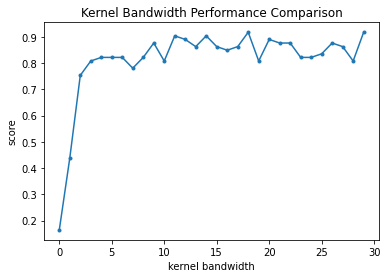

In [52]:

from sklearn.utils import shuffle

# a function used to select the best k 
def select_best_k(train_file, test_file, k_range):
    df = pd.read_csv(train_file, na_values = "9999.0000", header = None)
    df = df.dropna(axis=0, how='all', subset = [i for i in range(1, df.shape[1])])
    
    # a list of testable k values
    k_band = [x for x in range(k_range[0], k_range[1])]
    
    # a list of accuracy scores obtained by the validation set 
    scores = []
    for k in k_band:
        df = shuffle(df)
        validation_df = df.head(len(df)//10)
        train_df = df[~df.index.isin(validation_df.index)]
        train_data, stats, priors = KDE_train(train_df)
        y_test, y_pred = KDE_predict(k, stats, priors, validation_df, train_data)
        scores.append(evaluate(y_test, y_pred))
        
    # plot the accuracy perfomance vs different k
    fig = plt.figure()
    plt.plot(np.array(k_band), np.array(scores), marker = '.')    
    plt.xlabel('kernel bandwidth')
    plt.ylabel("score")
    plt.title("Kernel Bandwidth Performance Comparison")
    fig.savefig('figure1.png')
    
    # select the k value that maximizes accuracy score
    best_k_index = 0
    for i in scores:
        if i == max(scores):
            best_k_index = scores.index(i)
            break

    best_k = k_band[best_k_index]
    return best_k

print(select_best_k("train.csv", "test.csv", (0, 30)))


In [53]:
# compute the accuracy score using the test file 
train_df = pd.read_csv("train.csv", na_values = "9999.0000", header = None)
train_df = train_df.dropna(axis=0, how='all', subset = [i for i in range(1, train_df.shape[1])])
test_df = pd.read_csv("test.csv", na_values = "9999.0000", header = None)
train_data, stats, priors = KDE_train(train_df)
y_test, y_pred = KDE_predict(best_k, stats, priors, test_df, train_data)
accuracy = evaluate(y_test, y_pred)
# print(accuracy)
